In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import requests 
import io
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

import string
from nltk import word_tokenize
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 29.6 MB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 636 kB 29.2 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer,BertModel, BertConfig
import torch

### User Mapping

In [ ]:
orig_members = pd.read_csv('/content/drive/MyDrive/text gcn/Hackforum data/CSV Data IronMarch/data_csv/orig_members.csv')

In [ ]:
sorted_member_id = orig_members['member_id'].sort_values()
member_id_map ={}
start_id = 1
for id in sorted_member_id:
  member_id_map[id] = start_id
  start_id = start_id + 1

### Message Posts

In [ ]:
orig_inline_notifications = pd.read_csv('/content/drive/MyDrive/text gcn/Hackforum data/CSV Data IronMarch/data_csv/orig_inline_notifications.csv')
# orig_posts = pd.read_csv('/content/drive/MyDrive/text gcn/Hackforum data/CSV Data IronMarch/data_csv/orig_posts.csv')

In [ ]:
# orig_posts.info()

In [ ]:
orig_inline_notifications.drop(orig_inline_notifications.columns[[0,1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13]], axis =1, inplace=True)
# orig_posts.drop(orig_posts.columns[[0,1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]], axis =1, inplace=True)

In [ ]:
orig_inline_notifications.info()
# orig_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47066 entries, 0 to 47065
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   notify_text     47066 non-null  object
 1   notify_from_id  47066 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 735.5+ KB


### Functions

In [ ]:
def preprocess_text(text):

  # try:
    # print("here")
    soup = BeautifulSoup(text, "lxml")
    # print("hu")
    text = soup.body.text

    # Get a list of sentences, removes "\n"
    lst = sent_tokenize(text)
    text = " ".join(lst)

    text = text.replace("\n", "")

    # Preprocess using NLTK
    text = text.lower()

    # Remove Punctuation
    text_p = "".join([char for char in text if char not in string.punctuation])

    # Get a List of words 
    words = word_tokenize(text_p)

    words = " ".join(words)

    # Remove stopwords
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]

    ret = " ".join(filtered_words)

    return ret

  # except:
    # print(text)
    # return 0


In [ ]:
def getBERT(post):

# Get the embedding
  # tokens = tokenizer(post, return_tensors="pt")
  # tokens['input_ids'] = tokens['input_ids'][:512]
  # tokens['attention_mask'] = tokens['attention_mask'][:512]
  # tokens['token_type_ids'] = tokens['token_type_ids'][:512]
  tokens = tokenizer.encode_plus(post,return_tensors='pt', 
                                 max_length=512, truncation=True)
  # tokens = tokenizer.encode_plus(post, add_special_tokens=False, return_tensors='pt',
  #                                max_length=512, truncation=True, padding="max_length")
  # print(type(tokens))
  # tokens = tokens.long()
  # return inputs['input_ids'].shape[1]
  outputs = model(**tokens)
  last_hidden_states = outputs.last_hidden_state

# Take the average
  n_tensor = last_hidden_states.shape[1]
  vector = (last_hidden_states.sum(axis=1)/n_tensor)

  return vector

In [ ]:
# def get_word_split(text1):
#   l_total = []
#   l_partial = []
#   if len(text1.split())//150 >0:
#     n = len(text1.split())//150 + 1
#   else: 
#     n = 1
#   # print(n)
#   for w in range(n):
#     if w == 0:
#       l_partial = text1.split()[:200]
#       l_total.append(" ".join(l_partial))
#     else:
#       l_partial = text1.split()[w*150:w*150 + 200]
#       l_total.append(" ".join(l_partial))
#   return l_total

In [ ]:
# def get_tokens_split(text):
#   tokens = tokenizer.encode_plus(txt, add_special_tokens=False,
#                                return_tensors='pt')
#   input_id_chunks = tokens['input_ids'][0].split(510)
#   pad_len = 512 - input_id_chunks[i].shape[0]
#   if pad_len > 0:
#     # if padding length is more than 0, we must add padding
#     input_id_chunks[i] = torch.cat([
#         input_id_chunks[i], torch.Tensor([0] * pad_len)
#     ])
#   print(input_id_chunks.shape)
#   input_ids = torch.stack(input_id_chunks)
#   print(input_ids.shape)
#   input_dict = {
#     'input_ids': input_ids.long(),
#     # 'attention_mask': attention_mask.int()
#   }
#   return input_dict

### Variables

In [ ]:
# embedding = np.zeros((orig_members.shape[0], 768))
embedding = np.load("/content/drive/MyDrive/text gcn/node_feature/ironmarch/notifs_embedding/head/v5.0.npy")
count = np.zeros(orig_members.shape[0])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Iterations

In [ ]:
# lst = []
# for i, row in orig_inline_notifications.iterrows():
for i in range(25001, len(orig_inline_notifications)):
  row = orig_inline_notifications.iloc[i]
  author_id = row['notify_from_id']
  if author_id not in member_id_map:
          continue
  id = member_id_map[author_id]
  doc = row['notify_text']

  clean_doc = preprocess_text(doc)
  # lst.append(getBERT(clean_doc))
  # clean_chunks = get_split(clean_doc)

  
  embed_doc = getBERT(clean_doc)
  embed_doc = embed_doc.detach().numpy()

  # # print(id, len(clean_doc))
  # for chunkNo, chunk in enumerate(clean_chunks):
  #   embed_chunk = getBERT(chunk)
  #   embed_chunk = embed_chunk.detach().numpy()
  #   embed_doc = (embed_doc*chunkNo + embed_chunk)/(chunkNo+1)


  embedding[id] = (count[id]*embedding[id] + embed_doc)/(count[id]+1)
  count[id] = count[id]+1

  if i%5000==0:
    num = int(i/5000)
    np.save("/content/drive/MyDrive/text gcn/node_feature/ironmarch/notifs_embedding/head/v{}".format(num+1), embedding)


In [ ]:
notifs_embed = np.load("/content/drive/MyDrive/text gcn/node_feature/ironmarch/notifs_embedding/head/v10.npy")

In [ ]:
np.save("/content/drive/MyDrive/text gcn/node_feature/ironmarch/notifs_embedding/head/final", notifs_embed)

# Rough

In [ ]:
embedding.shape

(763, 768)

In [ ]:
arr = np.asarray(lst)
print(np.min(arr), np.max(arr), arr.sum()/len(lst))

2 25100 158.51693542164958


In [ ]:
np.argmax(arr)

869

(array([1.2106e+04, 5.4900e+02, 1.5800e+02, 6.6000e+01, 3.0000e+01,
        2.5000e+01, 9.0000e+00, 3.0000e+00, 3.0000e+00, 6.0000e+00]),
 array([2.0000e+00, 4.9290e+02, 9.8380e+02, 1.4747e+03, 1.9656e+03,
        2.4565e+03, 2.9474e+03, 3.4383e+03, 3.9292e+03, 4.4201e+03,
        4.9110e+03]),
 <a list of 10 Patch objects>)

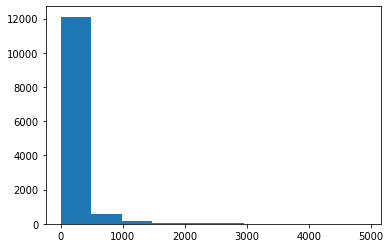

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.sort(arr)[:-6])

In [ ]:
len(orig_message_posts['msg_post'][980].split())

33

In [ ]:
arr = np.asarray(lst)
print(np.min(arr), np.max(arr), arr.sum()/len(lst))

2 266467 265.87713132795307


In [ ]:
embed_doc.shape

(1, 768)

In [ ]:
len(clean_doc)

2739

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
out = get_split(clean_doc)

In [ ]:
len(out)

1

In [ ]:
len(out[0].split())

200

In [ ]:
 len(clean_doc.split())

214

In [ ]:
 len(clean_doc.split())//150

1

In [ ]:
getBERT(out[0]).shape

torch.Size([1, 768])

In [ ]:
doc = orig_message_posts['msg_post'][3]
clean_doc = preprocess_text(doc)

In [ ]:
len(clean_doc)

94

In [ ]:
len(get_split(clean_doc))

1

In [ ]:
sent = "He remains characteristically confident and optimistic."
type(tokenizer(sent))

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
type(tokenizer.encode_plus(sent))

transformers.tokenization_utils_base.BatchEncoding